# Polynomial Model Complexity and Regularization

This notebook demonstrates how model complexity and regularization affect polynomial regression.

We will:
1. Generate synthetic **linear**, **quadratic**, and **sinusoidal** datasets with noisy edges.
2. Fit **high-degree polynomials (degree=12)** using OLS, Ridge, and Lasso.
3. Compare in-range fits, coefficient magnitudes, and high-degree behavior.
4. Show how Ridge and Lasso regularization control overfitting by shrinking or zeroing higher-order coefficients.

---
🔑 Key expectation:
- **OLS (unregularized)** → large unstable high-degree coefficients, fits noise.
- **Ridge** → shrinks all coefficients smoothly.
- **Lasso** → eliminates irrelevant higher-degree terms (sparse solution).

## Step 1: Generate synthetic datasets

- **Linear dataset**: $y = 2x + 1 + \epsilon$
- **Quadratic dataset**: $y = 0.8x^2 - 2x + 0.5 + \epsilon$
- **Sinusoidal dataset**: $y = \sin(x) + \epsilon$

To emphasize overfitting:
- Use small sample size ($n=30$).
- Add **edge-boosted noise** for linear & quadratic (larger noise near $|x| > 2.2$).
- Use **degree=12 polynomial features** to provoke coefficient explosion in OLS.

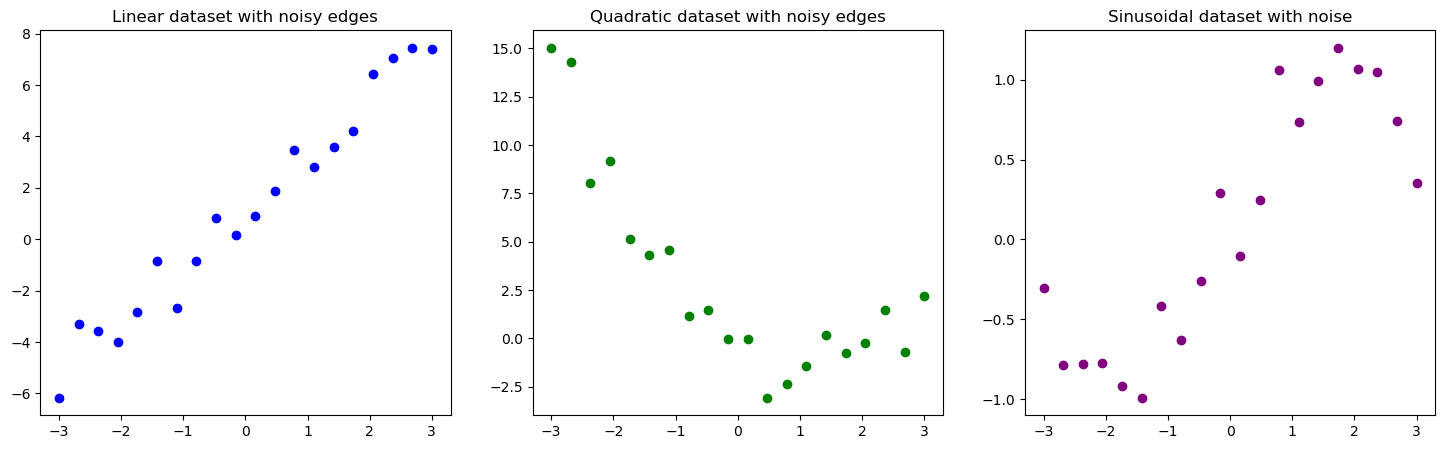

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress sklearn ConvergenceWarnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# --- Data generation ---
np.random.seed(123)
n = 20
x = np.linspace(-3, 3, n)
X = x.reshape(-1, 1)

# Linear dataset
noise_linear = np.random.normal(scale=0.6, size=n)
edge_boost = 1 + 0.8*(np.abs(x) > 2.4)
y_lin = (2*x + 1) + noise_linear * edge_boost

# Quadratic dataset
noise_quad = np.random.normal(scale=1.0, size=n)
edge_boost_q = 1 + 0.8*(np.abs(x) > 2.2)
y_quad = (0.8*x**2 - 2*x + 0.5) + noise_quad * edge_boost_q

# Sinusoidal dataset
noise_sin = np.random.normal(scale=0.2, size=n)
y_sin = np.sin(x) + noise_sin

# Plot datasets
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.scatter(x, y_lin, c="blue")
plt.title("Linear dataset with noisy edges")
plt.subplot(1,3,2)
plt.scatter(x, y_quad, c="green")
plt.title("Quadratic dataset with noisy edges")
plt.subplot(1,3,3)
plt.scatter(x, y_sin, c="purple")
plt.title("Sinusoidal dataset with noise")
plt.show()

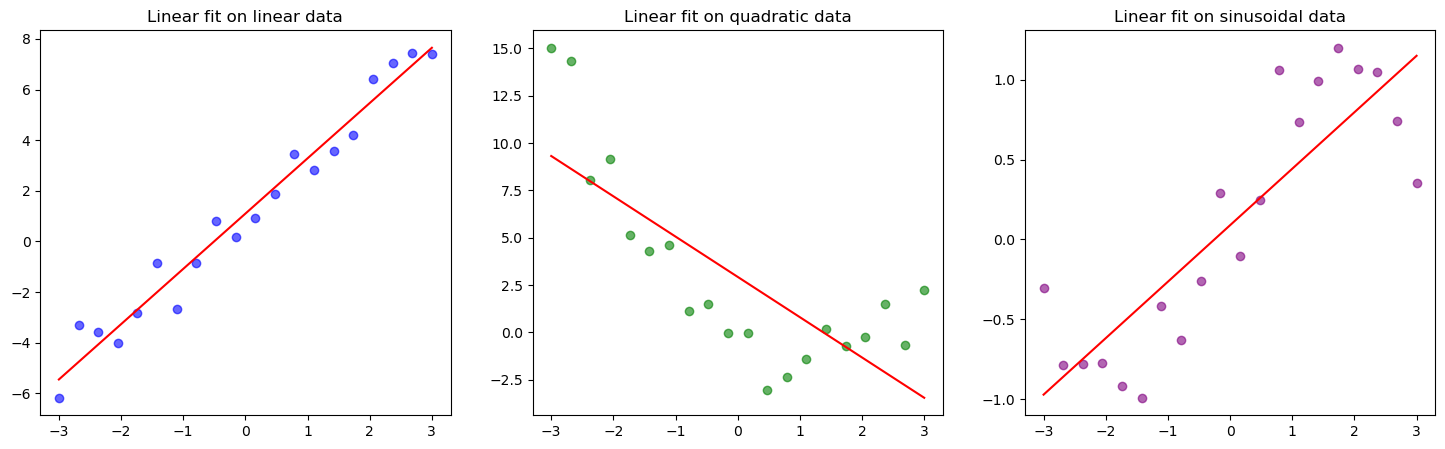

In [59]:
lin1 = LinearRegression().fit(X, y_lin)
lin2 = LinearRegression().fit(X, y_quad)
lin3 = LinearRegression().fit(X, y_sin)

y_pred1, y_pred2, y_pred3 = lin1.predict(X), lin2.predict(X), lin3.predict(X)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs[0].scatter(x, y_lin, c="blue", alpha=0.6); axs[0].plot(x, y_pred1, c="red"); axs[0].set_title("Linear fit on linear data")
axs[1].scatter(x, y_quad, c="green", alpha=0.6); axs[1].plot(x, y_pred2, c="red"); axs[1].set_title("Linear fit on quadratic data")
axs[2].scatter(x, y_sin, c="purple", alpha=0.6); axs[2].plot(x, y_pred3, c="red"); axs[2].set_title("Linear fit on sinusoidal data")
plt.show()

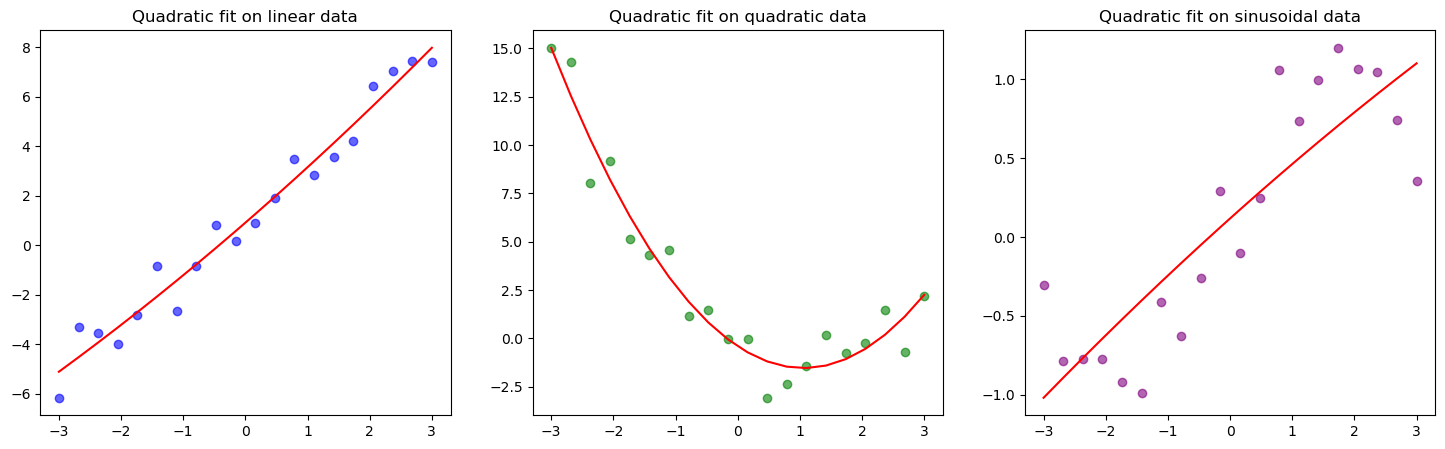

In [60]:
poly2 = PolynomialFeatures(degree=2)
X_poly2 = poly2.fit_transform(X)

quad1 = LinearRegression().fit(X_poly2, y_lin)
quad2 = LinearRegression().fit(X_poly2, y_quad)
quad3 = LinearRegression().fit(X_poly2, y_sin)

yq1, yq2, yq3 = quad1.predict(X_poly2), quad2.predict(X_poly2), quad3.predict(X_poly2)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs[0].scatter(x, y_lin, c="blue", alpha=0.6); axs[0].plot(x, yq1, c="red"); axs[0].set_title("Quadratic fit on linear data")
axs[1].scatter(x, y_quad, c="green", alpha=0.6); axs[1].plot(x, yq2, c="red"); axs[1].set_title("Quadratic fit on quadratic data")
axs[2].scatter(x, y_sin, c="purple", alpha=0.6); axs[2].plot(x, yq3, c="red"); axs[2].set_title("Quadratic fit on sinusoidal data")
plt.show()

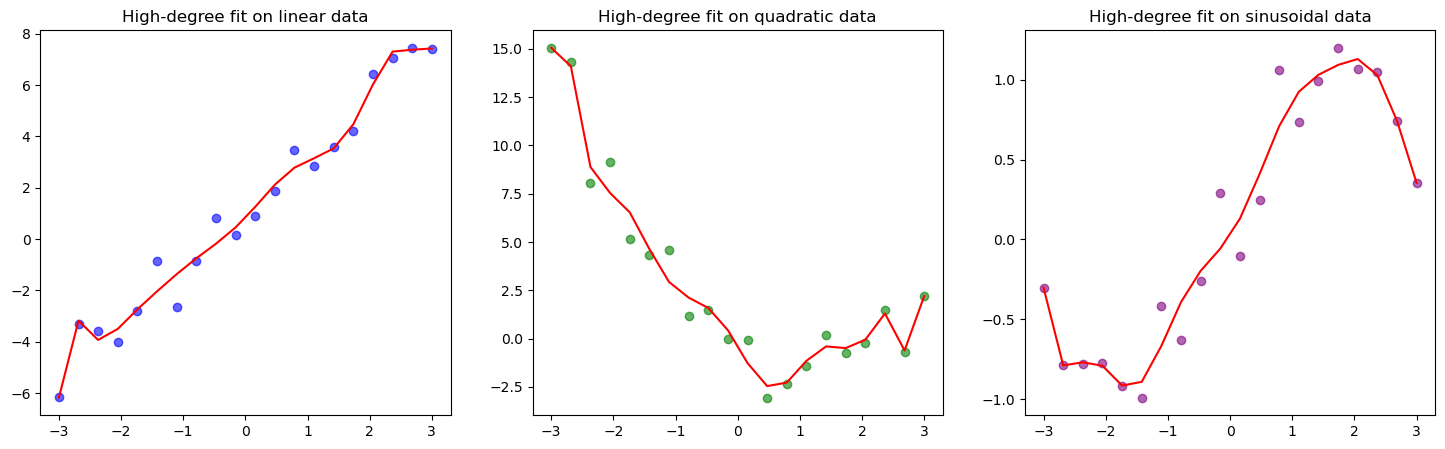

In [61]:
poly12 = PolynomialFeatures(degree=12)
X_poly12 = poly12.fit_transform(X)

high1 = LinearRegression().fit(X_poly12, y_lin)
high2 = LinearRegression().fit(X_poly12, y_quad)
high3 = LinearRegression().fit(X_poly12, y_sin)

yh1, yh2, yh3 = high1.predict(X_poly12), high2.predict(X_poly12), high3.predict(X_poly12)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs[0].scatter(x, y_lin, c="blue", alpha=0.6); axs[0].plot(x, yh1, c="red"); axs[0].set_title("High-degree fit on linear data")
axs[1].scatter(x, y_quad, c="green", alpha=0.6); axs[1].plot(x, yh2, c="red"); axs[1].set_title("High-degree fit on quadratic data")
axs[2].scatter(x, y_sin, c="purple", alpha=0.6); axs[2].plot(x, yh3, c="red"); axs[2].set_title("High-degree fit on sinusoidal data")
plt.show()

In [62]:
# Train-test split
X_train, X_test, y1_train, y1_test = train_test_split(X, y_lin, test_size=0.3, random_state=42)
_, _, y2_train, y2_test = train_test_split(X, y_quad, test_size=0.3, random_state=42)
_, _, y3_train, y3_test = train_test_split(X, y_sin, test_size=0.3, random_state=42)

def fit_and_eval(X_train, y_train, X_test, y_test, degree):
    poly = PolynomialFeatures(degree=degree)
    Xtr, Xte = poly.fit_transform(X_train), poly.transform(X_test)
    model = LinearRegression().fit(Xtr, y_train)
    return mean_squared_error(y_train, model.predict(Xtr)), mean_squared_error(y_test, model.predict(Xte))

results = {
    "Linear Data": {
        "Linear Fit": fit_and_eval(X_train, y1_train, X_test, y1_test, 1),
        "Quadratic Fit": fit_and_eval(X_train, y1_train, X_test, y1_test, 2),
        "High-degree Fit": fit_and_eval(X_train, y1_train, X_test, y1_test, 9),
    },
    "Quadratic Data": {
        "Linear Fit": fit_and_eval(X_train, y2_train, X_test, y2_test, 1),
        "Quadratic Fit": fit_and_eval(X_train, y2_train, X_test, y2_test, 2),
        "High-degree Fit": fit_and_eval(X_train, y2_train, X_test, y2_test, 9),
    },
    "Sinusoidal Data": {
        "Linear Fit": fit_and_eval(X_train, y3_train, X_test, y3_test, 1),
        "Quadratic Fit": fit_and_eval(X_train, y3_train, X_test, y3_test, 2),
        "High-degree Fit": fit_and_eval(X_train, y3_train, X_test, y3_test, 9),
    },
}

import pandas as pd
df_results = pd.DataFrame({
    (ds, model): {"Train MSE": tr, "Test MSE": te}
    for ds, models in results.items()
    for model, (tr, te) in models.items()
}).T
df_results

Train MSE     Test MSE
Linear Data     Linear Fit        0.330504     1.359502
                Quadratic Fit     0.295157     1.219074
                High-degree Fit   0.138032     2.319157
Quadratic Data  Linear Fit        6.673115    25.023499
                Quadratic Fit     1.301406     2.264938
                High-degree Fit   0.547079  1385.908754
Sinusoidal Data Linear Fit        0.140237     0.192406
                Quadratic Fit     0.098149     0.483031
                High-degree Fit   0.033579    25.209665

In [63]:
# Prepare high-degree polynomial features
poly_high = PolynomialFeatures(degree=12)
X_train_poly = poly_high.fit_transform(X_train)
X_test_poly = poly_high.transform(X_test)

def regularization_analysis(y_train, y_test, dataset_name):
    # Ridge with cross-validation
    ridge = RidgeCV(alphas=np.logspace(-3, 3, 50), cv=5).fit(X_train_poly, y_train)
    ridge_train_mse = mean_squared_error(y_train, ridge.predict(X_train_poly))
    ridge_test_mse = mean_squared_error(y_test, ridge.predict(X_test_poly))
    
    # Lasso with cross-validation
    lasso = LassoCV(alphas=np.logspace(-3, 1, 50), cv=5, max_iter=10000).fit(X_train_poly, y_train)
    lasso_train_mse = mean_squared_error(y_train, lasso.predict(X_train_poly))
    lasso_test_mse = mean_squared_error(y_test, lasso.predict(X_test_poly))
    
    return {
        "Ridge": (ridge_train_mse, ridge_test_mse, ridge.alpha_),
        "Lasso": (lasso_train_mse, lasso_test_mse, lasso.alpha_)
    }

# Apply to all datasets
reg_results = {
    "Linear Data": regularization_analysis(y1_train, y1_test, "Linear"),
    "Quadratic Data": regularization_analysis(y2_train, y2_test, "Quadratic"),
    "Sinusoidal Data": regularization_analysis(y3_train, y3_test, "Sinusoidal")
}

# Convert to table
df_reg_results = pd.DataFrame({
    (ds, model): {"Train MSE": tr, "Test MSE": te, "Alpha": alpha}
    for ds, models in reg_results.items()
    for model, (tr, te, alpha) in models.items()
}).T

df_reg_results


Train MSE      Test MSE       Alpha
Linear Data     Ridge   1.007508   7477.973552   19.306977
                Lasso   0.503397    217.684831    0.339322
Quadratic Data  Ridge   2.520488  11696.941022  244.205309
                Lasso   1.445488   2909.449356    0.409492
Sinusoidal Data Ridge   0.059871   1146.346472    4.714866
                Lasso   0.034662      2.920273    0.002560

## Step 2: Setup polynomial features and fit models

- Use **degree=12** polynomial features.
- Fit three models:
  - **OLS (unregularized)**
  - **Ridge regression** (with cross-validated α)
  - **Lasso regression** (with cross-validated α)


In [64]:
deg = 12
poly = PolynomialFeatures(degree=deg, include_bias=False)
Phi = poly.fit_transform(X)

def fit_models(y):
    ols = LinearRegression().fit(Phi, y)
    ridge = RidgeCV(alphas=np.logspace(-4, 2, 20), cv=5).fit(Phi, y)
    lasso = LassoCV(alphas=np.logspace(-4, -0.5, 18), cv=5, max_iter=100000).fit(Phi, y)
    return ols, ridge, lasso

ols_lin, ridge_lin, lasso_lin = fit_models(y_lin)
ols_quad, ridge_quad, lasso_quad = fit_models(y_quad)
ols_sin, ridge_sin, lasso_sin = fit_models(y_sin)

## Step 3: In-range fits

- Compare OLS, Ridge, and Lasso fits within the training range (-3 to 3).
- Expect OLS to overfit (wiggly), while Ridge and Lasso stabilize the curve.

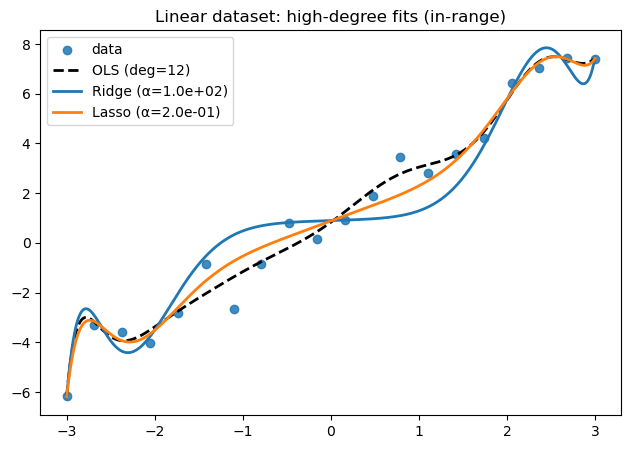

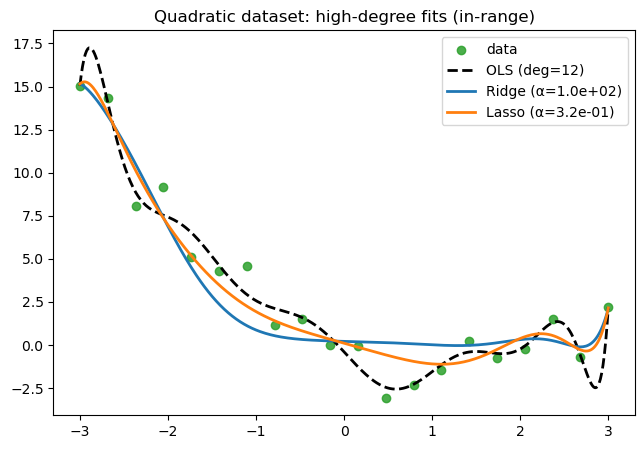

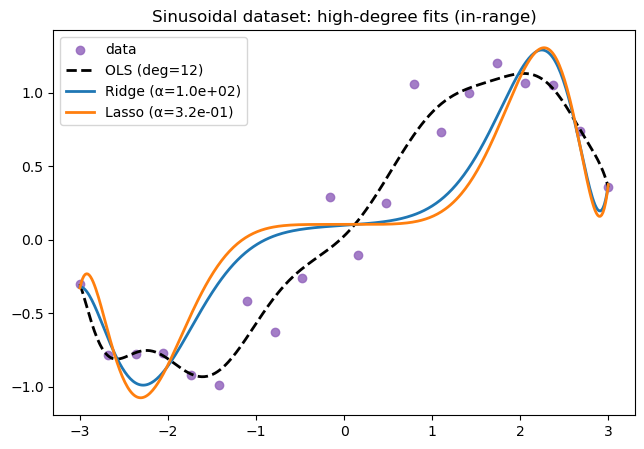

In [65]:
x_plot = np.linspace(-3, 3, 400).reshape(-1, 1)
Phi_plot = poly.transform(x_plot)

def show_fits(y, ols, ridge, lasso, title, color):
    plt.figure(figsize=(7.5,5))
    plt.scatter(X, y, c=color, alpha=0.85, label="data")
    plt.plot(x_plot, ols.predict(Phi_plot), 'k--', linewidth=2, label="OLS (deg=12)")
    plt.plot(x_plot, ridge.predict(Phi_plot), linewidth=2, label=f"Ridge (α={ridge.alpha_:.1e})")
    plt.plot(x_plot, lasso.predict(Phi_plot), linewidth=2, label=f"Lasso (α={lasso.alpha_:.1e})")
    plt.title(f"{title}: high-degree fits (in-range)")
    plt.legend()
    plt.show()

show_fits(y_lin,  ols_lin,  ridge_lin,  lasso_lin,  "Linear dataset",    "tab:blue")
show_fits(y_quad, ols_quad, ridge_quad, lasso_quad, "Quadratic dataset", "tab:green")
show_fits(y_sin,  ols_sin,  ridge_sin,  lasso_sin,  "Sinusoidal dataset","tab:purple")

## Step 4: Coefficient magnitudes by polynomial degree

- Plot coefficients by polynomial degree index (1–12).
- Expect:
  - **OLS** → large, unstable coefficients at higher degrees.
  - **Ridge** → shrinks them smoothly.
  - **Lasso** → sets many high-order coefficients exactly to zero.

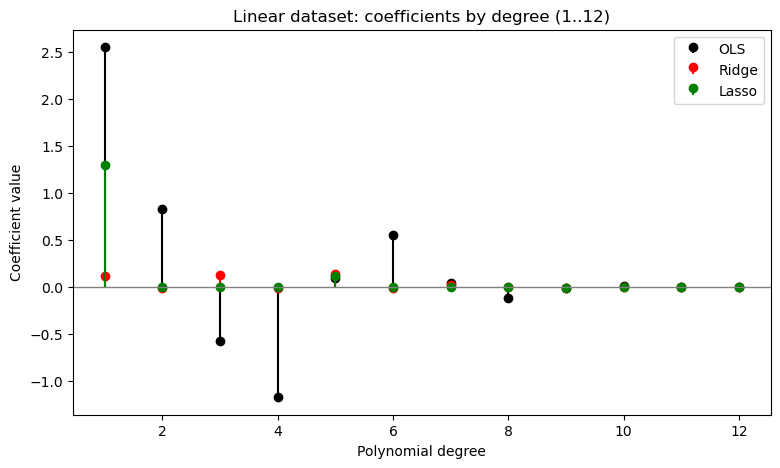

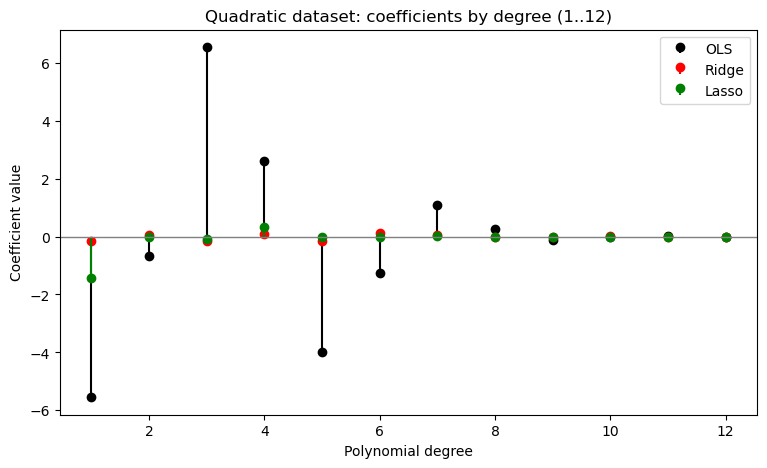

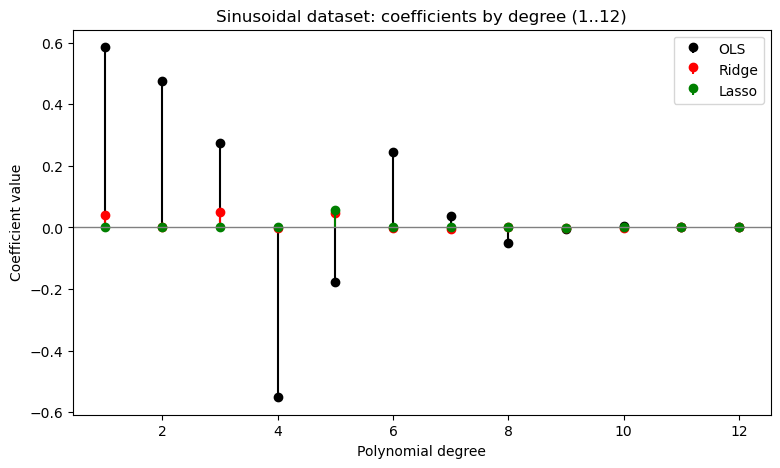

In [66]:
def stem_coeffs(ols, ridge, lasso, title):
    degrees = np.arange(1, deg+1)
    plt.figure(figsize=(9,5))
    plt.stem(degrees, ols.coef_, linefmt='k-', markerfmt='ko', basefmt=" ", label="OLS")
    plt.stem(degrees, ridge.coef_, linefmt='r-', markerfmt='ro', basefmt=" ", label="Ridge")
    plt.stem(degrees, lasso.coef_, linefmt='g-', markerfmt='go', basefmt=" ", label="Lasso")
    plt.axhline(0, color="gray", lw=1)
    plt.title(f"{title}: coefficients by degree (1..{deg})")
    plt.xlabel("Polynomial degree")
    plt.ylabel("Coefficient value")
    plt.legend()
    plt.show()

stem_coeffs(ols_lin,  ridge_lin,  lasso_lin,  "Linear dataset")
stem_coeffs(ols_quad, ridge_quad, lasso_quad, "Quadratic dataset")
stem_coeffs(ols_sin,  ridge_sin,  lasso_sin,  "Sinusoidal dataset")

## Step 5: High-degree tails (degrees 6–12)

- Compare only the higher-order coefficients (where overfitting happens).
- Expect OLS to blow up, Ridge to shrink, Lasso to zero them.

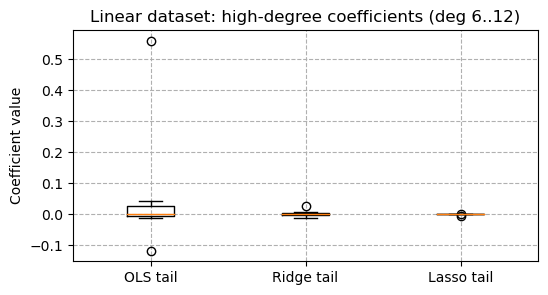

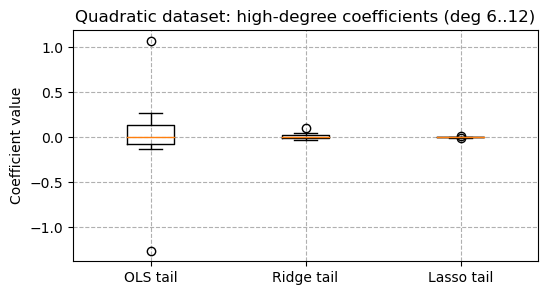

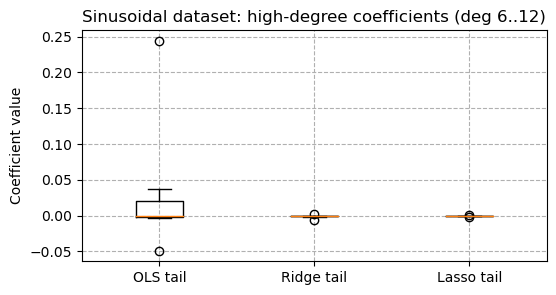

In [69]:
def tail_boxplots(ols, ridge, lasso, title, start_deg=6):
    sl = start_deg - 1  # coef index starts at degree 1 -> index 0
    coefs_ols = ols.coef_[sl:deg]
    coefs_r   = ridge.coef_[sl:deg]
    coefs_l   = lasso.coef_[sl:deg]
    plt.figure(figsize=(6,3))
    plt.boxplot([coefs_ols, coefs_r, coefs_l], labels=["OLS tail", "Ridge tail", "Lasso tail"])
    plt.title(f"{title}: high-degree coefficients (deg {start_deg}..{deg})")
    plt.ylabel("Coefficient value")
    plt.grid(ls="--")
    plt.show()

tail_boxplots(ols_lin,  ridge_lin,  lasso_lin,  "Linear dataset")
tail_boxplots(ols_quad, ridge_quad, lasso_quad, "Quadratic dataset")
tail_boxplots(ols_sin,  ridge_sin,  lasso_sin,  "Sinusoidal dataset")

## Step 6: Discussion

- **OLS (deg=12)** → Fits the noise, coefficients explode at higher degrees.
- **Ridge** → Shrinks high-degree coefficients, smoother fit, less variance.
- **Lasso** → Eliminates many high-degree coefficients, effectively reducing the model back to a simpler polynomial.

🔑 **Takeaway**: Regularization stabilizes polynomial regression by controlling the effective degree of the model, especially evident in the quadratic and sinusoidal cases.